<a href="https://colab.research.google.com/github/0xflame-7/deepdata-archive/blob/main/customer_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [264]:
from google.colab import userdata

In [265]:
KAGGLE_USERNAME = userdata.get("KAGGLE_USER")
KAGGLE_KEY = userdata.get("KAGGLE_TOKEN")

In [266]:
cred = {
    "username": KAGGLE_USERNAME,
    "key": KAGGLE_KEY
}
cred

{'username': 'flame7x0', 'key': '893616eeaa7eae6446aa4753fd9571f0'}

In [267]:
import os, json

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

In [268]:
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(cred, f)

In [269]:
!cat /root/.kaggle/kaggle.json

{"username": "flame7x0", "key": "893616eeaa7eae6446aa4753fd9571f0"}

In [270]:
!chmod 600 /root/.kaggle/kaggle.json

In [271]:
!kaggle datasets download mathchi/churn-for-bank-customers --force

Dataset URL: https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers
License(s): CC0-1.0
  0% 0.00/261k [00:00<?, ?B/s]
100% 261k/261k [00:00<00:00, 604MB/s]


In [272]:
!unzip -f churn-for-bank-customers.zip
!rm churn-for-bank-customers.zip

Archive:  churn-for-bank-customers.zip


Problem 1

In [273]:
# Problem 1: Data Preprocessing & Analysis
# Dataset: churn-for-bank-customers.csv
# Tasks: Missing values, outliers, encoding, standardization/normalization

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [275]:
df = pd.read_csv("/content/churn.csv")

In [276]:
# Step 1: Handle Missing Values and Drop Irrelevant Columns
print("Step 1: Handling Missing Values and Dropping Irrelevant Columns")
print(df.isnull().sum())  # Check for missing values
# Since no missing values (as per info), no imputation needed
# If there were, e.g., df['CreditScore'].fillna(df['CreditScore'].median(), inplace=True)


Step 1: Handling Missing Values and Dropping Irrelevant Columns
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [277]:
# Drop unnecessary columns (index, ID, text) including Surname
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
print(f"Shape after dropping columns: {df.shape}")


Shape after dropping columns: (10000, 11)



Step 2: Outlier Detection and Handling
CreditScore outliers: 15
Age outliers: 359
Tenure outliers: 0
Balance outliers: 0
NumOfProducts outliers: 60
EstimatedSalary outliers: 0


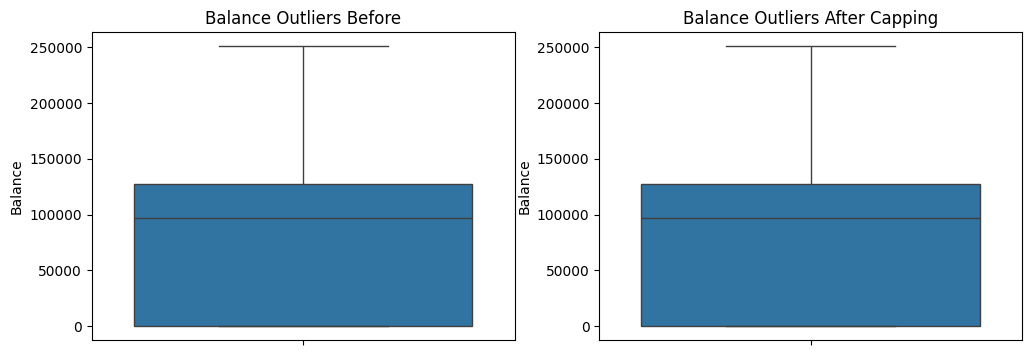

In [278]:
# Step 2: Outlier Detection and Handling
print("\nStep 2: Outlier Detection and Handling")
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
# Create a copy of the dataframe before outlier handling for visualization
df_original = df.copy()
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    print(f"{col} outliers: {len(outliers)}")
    # Handle outliers: Cap them (winsorize) instead of removing for now
    df[col] = np.clip(df[col], lower_bound, upper_bound)

# Visualize outliers before/after (optional)
# For example, for Balance:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(data=df_original['Balance'])  # Assuming df_original is pre-clipped copy
plt.title('Balance Outliers Before')
plt.subplot(1, 2, 2)
sns.boxplot(data=df['Balance'])
plt.title('Balance Outliers After Capping')
plt.show()


In [279]:
# Step 3: Encoding Categorical Variables
print("\nStep 3: Encoding Categorical Variables")
categorical_cols = ['Geography', 'Gender']
# One-hot encoding for low cardinality
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("Encoded columns:", df_encoded.columns.tolist())

# HasCrCard and IsActiveMember are already 0/1, no change needed
# Exited is target, keep as is



Step 3: Encoding Categorical Variables
Encoded columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']


In [280]:
# Step 4: Standardization/Normalization
print("\nStep 4: Standardization/Normalization")
scaler = StandardScaler()
# Select numerical columns for scaling (exclude target and binaries)
scale_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded[scale_cols]),
                         columns=scale_cols, index=df_encoded.index)
df_final = pd.concat([df_encoded.drop(scale_cols, axis=1), df_scaled], axis=1)
print("Scaled features mean/std (should be ~0/1):")
print(df_final[scale_cols].describe().loc[['mean', 'std']])

# Alternative: Normalization (Min-Max to [0,1])
# from sklearn.preprocessing import MinMaxScaler
# normalizer = MinMaxScaler()
# df_final[scale_cols] = normalizer.fit_transform(df_final[scale_cols])



Step 4: Standardization/Normalization
Scaled features mean/std (should be ~0/1):
       CreditScore           Age        Tenure       Balance  NumOfProducts  \
mean  4.121148e-16 -2.092548e-16 -1.078249e-16 -6.252776e-17   1.943334e-16   
std   1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   1.000050e+00   

      EstimatedSalary  
mean    -2.877698e-17  
std      1.000050e+00  


In [281]:
# Step 5: Handle Imbalance
print("\nStep 5: Handle Class Imbalance")
# Drop 'Surname' column before splitting for SMOTE
X = df_final.drop('Exited', axis=1)
y = df_final['Exited']
print(f"Original class distribution:\n{y.value_counts(normalize=True)}")



Step 5: Handle Class Imbalance
Original class distribution:
Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


# Problem 5

In [282]:
# 1: SMOTE (Oversampling)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print(f"SMOTE class distribution:\npd.Series(y_smote).value_counts(normalize=True)}}")

# Use SMOTE for this example
X_processed = X_smote
y_processed = y_smote

SMOTE class distribution:
pd.Series(y_smote).value_counts(normalize=True)}


In [283]:
# Step 6: Transformation (e.g., Log Transform for Skewed Features)
print("\nStep 6: Data Transformation")
# Check skewness for Balance (often right-skewed)
skewness = df['Balance'].skew()
print(f"Original Balance skewness: {skewness}")
if skewness > 1:
    # Log transform (add 1 to avoid log(0))
    df_final['Balance_log'] = np.log1p(df_final['Balance'])
    # Drop original if using log
    df_final = df_final.drop('Balance', axis=1)
    scale_cols.remove('Balance')
    scale_cols.append('Balance_log')
    # Rescale the new feature
    df_final['Balance_log'] = scaler.fit_transform(df_final[['Balance_log']])
    print("Applied log transform to Balance")



Step 6: Data Transformation
Original Balance skewness: -0.14110871094154384



Step 7: Feature Engineering
New features added: RiskScore, ProductActivity, CreditAgeRatio
Final processed shape: (15926, 14)


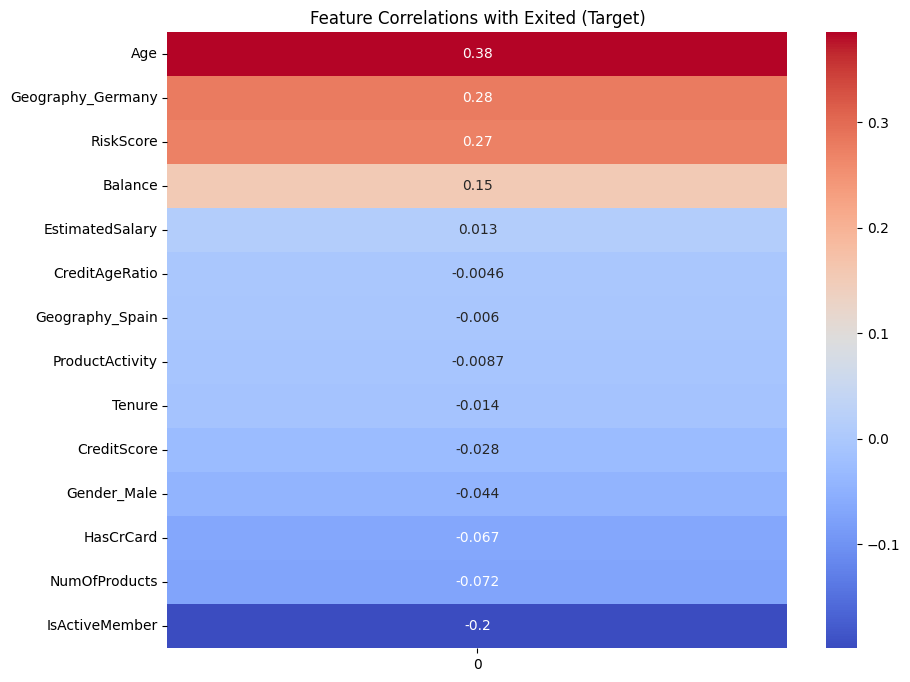

Train/Test split: (12740, 14), (3186, 14)


In [284]:
# Step 7: Feature Engineering
print("\nStep 7: Feature Engineering")
# Create new features, e.g., RiskScore = Age * (1 - IsActiveMember) + Balance/10000 (scaled already, but adjust)
df_final['RiskScore'] = df_final['Age'] + (df_final['Balance'] * 0.1) - (df_final['IsActiveMember'] * 10)
# Another: ProductActivity = NumOfProducts * IsActiveMember
df_final['ProductActivity'] = df_final['NumOfProducts'] * df_final['IsActiveMember']
# CreditAgeRatio = CreditScore / Age (avoid div by 0, but Age min~18)
df_final['CreditAgeRatio'] = df_final['CreditScore'] / (df_final['Age'] + 1)

# Update X with new features
X = df_final.drop('Exited', axis=1)
y = df_final['Exited']

# Re-apply SMOTE after engineering
smote = SMOTE(random_state=42) # Re-initialize SMOTE
X_smote, y_smote = smote.fit_resample(X, y)
print("New features added: RiskScore, ProductActivity, CreditAgeRatio")
print(f"Final processed shape: {X_smote.shape}")

# Optional: Correlation heatmap to check new features
plt.figure(figsize=(10, 8))
sns.heatmap(X_smote.corrwith(y_smote).sort_values(ascending=False).to_frame(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations with Exited (Target)')
plt.show()

# Split for ML (optional next step)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)
print(f"Train/Test split: {X_train.shape}, {X_test.shape}")